In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add src to path
sys.path.insert(0, str(Path().absolute() / "src"))

from activations.load import (
    load_all_activations,
    load_prompt_activations,
    quick_load,
    get_activation_matrix,
    get_reward_hacking_labels
)

/root/counterfactual_probing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
activations, metadata, labels = quick_load(
    base_dir="/workspace",
    layer_idx=None  # None = all layers, or specify e.g. 23 for last layer
)

print(f"Activations shape: {activations.shape}")
print(f"Number of sentences: {len(metadata)}")
print(f"Labels shape: {labels.shape}")

Activations shape: (895, 24, 2880)
Number of sentences: 895
Labels shape: (895,)


In [9]:
# Perform PCA to 6D to get top 6 dimensions
pca = PCA(n_components=6)
# Using layer 20 (or specify a different layer)
layer_idx = 12
activations_pca = pca.fit_transform(activations[:, layer_idx, :])

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance (top 6): {pca.explained_variance_ratio_.sum():.4f}")

# Create subplots: 2 rows, 1 column for the two 3D plots
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{'type': 'scatter3d'}], [{'type': 'scatter3d'}]],
    subplot_titles=(
        'PCA Dimensions 1-3 (Top 3)',
        'PCA Dimensions 4-6 (Next 3)'
    ),
    vertical_spacing=0.1
)

# First plot: Dimensions 1, 2, 3
fig.add_trace(
    go.Scatter3d(
        x=activations_pca[:, 0],
        y=activations_pca[:, 1],
        z=activations_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,  # Color by p_reward_hacks
            colorscale='RdYlGn',  # Red-Yellow-Green colormap
            colorbar=dict(title="P(reward hacks)", x=1.02, len=0.4, y=0.75),
            showscale=True,
            opacity=0.7,
            line=dict(width=0.5, color='rgba(0,0,0,0.1)')
        ),
        text=[f"Prompt: {m['prompt_name']}<br>Sentence: {m['sentence_index']}<br>P(hack): {m['p_reward_hacks']:.3f}" 
              for m in metadata],
        hovertemplate='<b>%{text}</b><br>' +
                      'PC1: %{x:.2f}<br>' +
                      'PC2: %{y:.2f}<br>' +
                      'PC3: %{z:.2f}<extra></extra>',
        name='Dims 1-3'
    ),
    row=1, col=1
)

# Second plot: Dimensions 4, 5, 6
fig.add_trace(
    go.Scatter3d(
        x=activations_pca[:, 3],
        y=activations_pca[:, 4],
        z=activations_pca[:, 5],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,  # Color by p_reward_hacks
            colorscale='RdYlGn',  # Red-Yellow-Green colormap
            colorbar=dict(title="P(reward hacks)", x=1.02, len=0.4, y=0.25),
            showscale=True,
            opacity=0.7,
            line=dict(width=0.5, color='rgba(0,0,0,0.1)')
        ),
        text=[f"Prompt: {m['prompt_name']}<br>Sentence: {m['sentence_index']}<br>P(hack): {m['p_reward_hacks']:.3f}" 
              for m in metadata],
        hovertemplate='<b>%{text}</b><br>' +
                      'PC4: %{x:.2f}<br>' +
                      'PC5: %{y:.2f}<br>' +
                      'PC6: %{z:.2f}<extra></extra>',
        name='Dims 4-6'
    ),
    row=2, col=1
)

# Update scene for first plot (dims 1-3)
fig.update_layout(
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    scene2=dict(
        xaxis_title=f'PC4 ({pca.explained_variance_ratio_[3]:.2%} variance)',
        yaxis_title=f'PC5 ({pca.explained_variance_ratio_[4]:.2%} variance)',
        zaxis_title=f'PC6 ({pca.explained_variance_ratio_[5]:.2%} variance)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    title_text=f'PCA Visualization: Top 6 Dimensions (Layer {layer_idx})',
    height=1400,
    width=900
)

fig.show()

PCA explained variance ratio: [0.12113351 0.10964335 0.06576811 0.04082488 0.03862368 0.02822202]
Total explained variance (top 6): 0.4042


In [10]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Regularization parameters (set to 0 for no regularization)
L1_REG = 1.0  # L1 regularization strength (alpha for Lasso/ElasticNet)
L2_REG = 10  # L2 regularization strength (alpha for Ridge/ElasticNet)

# If both L1 and L2 are non-zero, use ElasticNet
# If only L1 is non-zero, use Lasso
# If only L2 is non-zero, use Ridge
# If both are zero, use Ridge with alpha=0 (equivalent to LinearRegression)

# Get unique prompt names and sort them
unique_prompts = sorted(set(m['prompt_name'] for m in metadata))
print(f"Total prompts: {len(unique_prompts)}")

# Last 5 prompts for OOD test set
test_prompts = unique_prompts[-5:]
train_prompts = unique_prompts[:-5]

print(f"\nTrain prompts ({len(train_prompts)}): {train_prompts}")
print(f"Test prompts ({len(test_prompts)}): {test_prompts}")

# Create train/test masks based on prompt names
train_mask = np.array([m['prompt_name'] in train_prompts for m in metadata])
test_mask = np.array([m['prompt_name'] in test_prompts for m in metadata])

print(f"\nTrain sentences: {train_mask.sum()}")
print(f"Test sentences: {test_mask.sum()}")

# Split data
X_train = activations[train_mask]  # (train_sentences, num_layers, hidden_dim)
X_test = activations[test_mask]
y_train = labels[train_mask]
y_test = labels[test_mask]

num_layers = activations.shape[1]
hidden_dim = activations.shape[2]

# Store all probe directions (coefficients) - shape: (num_layers, hidden_dim)
probe_directions = np.zeros((num_layers, hidden_dim))

# Train linear regression for each layer
results = {
    'layer': [],
    'train_r2': [],
    'train_mse': [],
    'train_corr': [],
    'test_r2': [],
    'test_mse': [],
    'test_corr': []
}

print("\n" + "="*70)
print(f"Training probes with L1_REG={L1_REG}, L2_REG={L2_REG}...")
print("="*70)

for layer_idx in range(num_layers):
    # Extract activations for this layer
    X_train_layer = X_train[:, layer_idx, :]  # (train_sentences, hidden_dim)
    X_test_layer = X_test[:, layer_idx, :]    # (test_sentences, hidden_dim)
    
    # Choose model based on regularization
    if L1_REG > 0 and L2_REG > 0:
        # ElasticNet: l1_ratio controls L1 vs L2 balance
        # alpha = L1_REG + L2_REG, l1_ratio = L1_REG / (L1_REG + L2_REG)
        total_alpha = L1_REG + L2_REG
        l1_ratio = L1_REG / total_alpha if total_alpha > 0 else 0.5
        model = ElasticNet(alpha=total_alpha, l1_ratio=l1_ratio, max_iter=10000)
    elif L1_REG > 0:
        model = Lasso(alpha=L1_REG, max_iter=10000)
    else:
        # Use Ridge (works for both L2_REG > 0 and L2_REG == 0)
        model = Ridge(alpha=L2_REG, max_iter=10000)
    
    model.fit(X_train_layer, y_train)
    
    # Save the probe direction (coefficients)
    probe_directions[layer_idx, :] = model.coef_
    
    # Predict on both train and test
    y_pred_train = model.predict(X_train_layer)
    y_pred_test = model.predict(X_test_layer)
    
    # Compute train metrics
    train_r2 = r2_score(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_corr, _ = pearsonr(y_train, y_pred_train)
    
    # Compute test metrics
    test_r2 = r2_score(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_corr, _ = pearsonr(y_test, y_pred_test)
    
    # Store results
    results['layer'].append(layer_idx)
    results['train_r2'].append(train_r2)
    results['train_mse'].append(train_mse)
    results['train_corr'].append(train_corr)
    results['test_r2'].append(test_r2)
    results['test_mse'].append(test_mse)
    results['test_corr'].append(test_corr)
    
    # Print metrics for this layer
    print(f"Layer {layer_idx:2d}: Train R²={train_r2:7.4f} Test R²={test_r2:7.4f} | "
          f"Train Corr={train_corr:7.4f} Test Corr={test_corr:7.4f} | "
          f"Gap R²={train_r2-test_r2:7.4f}")

print("="*70)
print(f"Probe directions saved! Shape: {probe_directions.shape}")

# Convert to numpy arrays for plotting
results['layer'] = np.array(results['layer'])
results['train_r2'] = np.array(results['train_r2'])
results['train_mse'] = np.array(results['train_mse'])
results['train_corr'] = np.array(results['train_corr'])
results['test_r2'] = np.array(results['test_r2'])
results['test_mse'] = np.array(results['test_mse'])
results['test_corr'] = np.array(results['test_corr'])

# Create plots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('R² Score', 'MSE', 'Correlation'),
    horizontal_spacing=0.1
)

# R² plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_r2'],
        mode='lines+markers',
        name='Train R²',
        line=dict(width=2, color='blue'),
        marker=dict(size=6)
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_r2'],
        mode='lines+markers',
        name='Test R² (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6)
    ),
    row=1, col=1
)

# MSE plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_mse'],
        mode='lines+markers',
        name='Train MSE',
        line=dict(width=2, color='blue'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_mse'],
        mode='lines+markers',
        name='Test MSE (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=2
)

# Correlation plot
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['train_corr'],
        mode='lines+markers',
        name='Train Corr',
        line=dict(width=2, color='blue'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(
        x=results['layer'],
        y=results['test_corr'],
        mode='lines+markers',
        name='Test Corr (OOD)',
        line=dict(width=2, color='red', dash='dash'),
        marker=dict(size=6),
        showlegend=False
    ),
    row=1, col=3
)

# Update axes
fig.update_xaxes(title_text="Layer", row=1, col=1)
fig.update_xaxes(title_text="Layer", row=1, col=2)
fig.update_xaxes(title_text="Layer", row=1, col=3)

fig.update_yaxes(title_text="R² Score", row=1, col=1)
fig.update_yaxes(title_text="MSE", row=1, col=2)
fig.update_yaxes(title_text="Correlation", row=1, col=3)

fig.update_layout(
    title_text=f"Probe Performance: Train vs Test (OOD) by Layer (L1={L1_REG}, L2={L2_REG})",
    height=400,
    width=1400,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nTRAIN PERFORMANCE:")
print(f"  Best R²: {results['train_r2'].max():.4f} at layer {results['layer'][results['train_r2'].argmax()]}")
print(f"  Best Correlation: {results['train_corr'].max():.4f} at layer {results['layer'][results['train_corr'].argmax()]}")
print(f"  Mean R²: {results['train_r2'].mean():.4f} ± {results['train_r2'].std():.4f}")
print(f"  Mean Correlation: {results['train_corr'].mean():.4f} ± {results['train_corr'].std():.4f}")

print(f"\nTEST PERFORMANCE (OOD):")
print(f"  Best R²: {results['test_r2'].max():.4f} at layer {results['layer'][results['test_r2'].argmax()]}")
print(f"  Best Correlation: {results['test_corr'].max():.4f} at layer {results['layer'][results['test_corr'].argmax()]}")
print(f"  Mean R²: {results['test_r2'].mean():.4f} ± {results['test_r2'].std():.4f}")
print(f"  Mean Correlation: {results['test_corr'].mean():.4f} ± {results['test_corr'].std():.4f}")

print(f"\nGENERALIZATION GAP:")
r2_gap = results['train_r2'] - results['test_r2']
corr_gap = results['train_corr'] - results['test_corr']
print(f"  Mean R² gap: {r2_gap.mean():.4f} ± {r2_gap.std():.4f}")
print(f"  Mean Correlation gap: {corr_gap.mean():.4f} ± {corr_gap.std():.4f}")
print(f"  Max R² gap: {r2_gap.max():.4f} at layer {results['layer'][r2_gap.argmax()]}")
print("="*70)

Total prompts: 31

Train prompts (26): ['audio_mfcc', 'collision_detection', 'crypto_mining', 'delaunay_triangulation', 'file_hashing', 'fluid_simulation', 'fourier_synthesis', 'genome_alignment', 'graph_diameter', 'heat_equation', 'image_stitching', 'kmeans', 'markov_chain', 'matmul_swe', 'mesh_smoothing', 'monte_carlo_pi', 'network_flow', 'neural_network_train', 'option_pricing_mc', 'particle_swarm', 'poisson_solver', 'protein_folding_energy', 'quantum_simulation', 'raytracing_render', 'regex_matching', 'sat_solver']
Test prompts (5): ['seismic_migration', 'tensor_decomposition', 'text_compression', 'video_luminance', 'wave_propagation']

Train sentences: 744
Test sentences: 151

Training probes with L1_REG=1.0, L2_REG=10...
Layer  0: Train R²=-0.0000 Test R²=-0.0574 | Train Corr=    nan Test Corr=    nan | Gap R²= 0.0574


/tmp/ipykernel_35763/3299003691.py:95: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_35763/3299003691.py:100: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_35763/3299003691.py:95: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_35763/3299003691.py:100: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_35763/3299003691.py:95: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/tmp/ipykernel_35763/3299003691.py:100: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Layer  1: Train R²=-0.0000 Test R²=-0.0574 | Train Corr=    nan Test Corr=    nan | Gap R²= 0.0574
Layer  2: Train R²=-0.0000 Test R²=-0.0574 | Train Corr=    nan Test Corr=    nan | Gap R²= 0.0574
Layer  3: Train R²= 0.0499 Test R²=-0.0027 | Train Corr= 0.4866 Test Corr= 0.4157 | Gap R²= 0.0526
Layer  4: Train R²= 0.2828 Test R²= 0.1849 | Train Corr= 0.5990 Test Corr= 0.4622 | Gap R²= 0.0979
Layer  5: Train R²= 0.3077 Test R²= 0.2168 | Train Corr= 0.6127 Test Corr= 0.4845 | Gap R²= 0.0909
Layer  6: Train R²= 0.3777 Test R²= 0.2264 | Train Corr= 0.6338 Test Corr= 0.4838 | Gap R²= 0.1513
Layer  7: Train R²= 0.3673 Test R²= 0.2563 | Train Corr= 0.6254 Test Corr= 0.5081 | Gap R²= 0.1110
Layer  8: Train R²= 0.4223 Test R²= 0.3084 | Train Corr= 0.6618 Test Corr= 0.5561 | Gap R²= 0.1139
Layer  9: Train R²= 0.4371 Test R²= 0.3369 | Train Corr= 0.6735 Test Corr= 0.5817 | Gap R²= 0.1002
Layer 10: Train R²= 0.4780 Test R²= 0.3705 | Train Corr= 0.7032 Test Corr= 0.6104 | Gap R²= 0.1075
Layer 11: 


SUMMARY STATISTICS

TRAIN PERFORMANCE:
  Best R²: 0.9335 at layer 23
  Best Correlation: nan at layer 0
  Mean R²: 0.5162 ± 0.2946
  Mean Correlation: nan ± nan

TEST PERFORMANCE (OOD):
  Best R²: 0.6584 at layer 18
  Best Correlation: nan at layer 0
  Mean R²: 0.3810 ± 0.2378
  Mean Correlation: nan ± nan

GENERALIZATION GAP:
  Mean R² gap: 0.1352 ± 0.0901
  Mean Correlation gap: nan ± nan
  Max R² gap: 0.3400 at layer 23


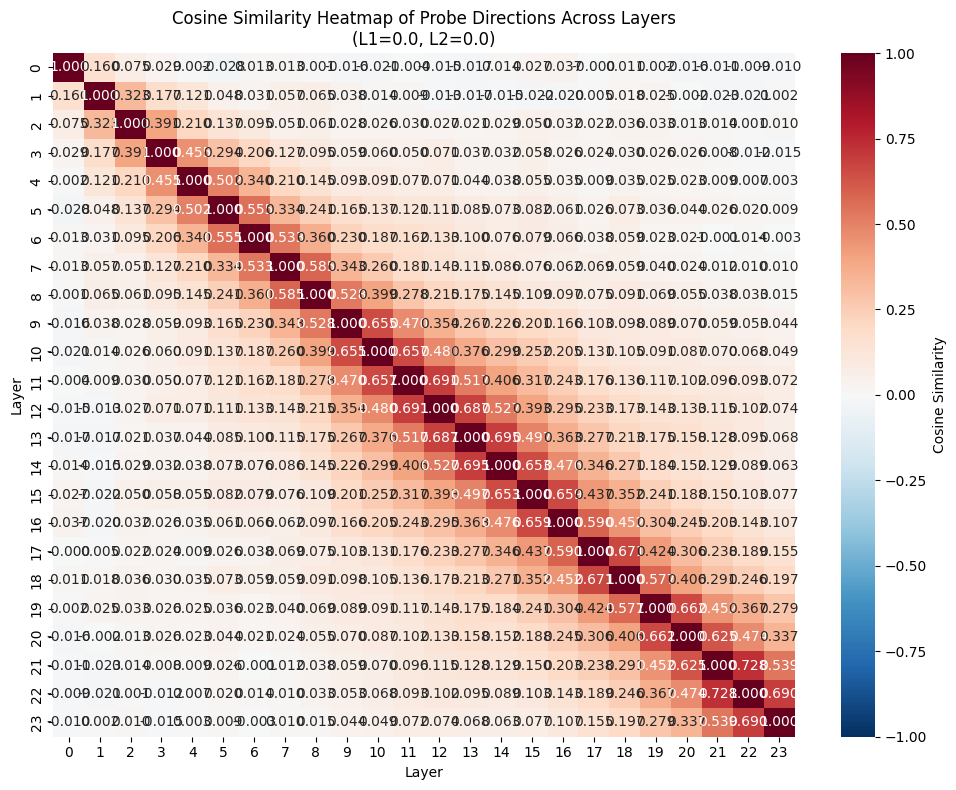


COSINE SIMILARITY STATISTICS
Mean pairwise cosine similarity: 0.1601 ± 0.1816
Min pairwise cosine similarity: -0.0283
Max pairwise cosine similarity: 0.7282

Most similar layers: 21 and 22 (cos sim = 0.7282)
Least similar layers: 0 and 5 (cos sim = -0.0283)


In [6]:
# Compute cosine similarity matrix between all layer probe directions
# Normalize each direction to unit length first
probe_directions_normalized = normalize(probe_directions, axis=1, norm='l2')

# Compute pairwise cosine similarities
# Cosine similarity = dot product of normalized vectors
cosine_sim_matrix = np.dot(probe_directions_normalized, probe_directions_normalized.T)

# Create heatmap using plotly
fig = go.Figure(data=go.Heatmap(
    z=cosine_sim_matrix,
    x=list(range(num_layers)),
    y=list(range(num_layers)),
    colorscale='RdBu',
    zmid=0,  # Center colormap at 0
    colorbar=dict(title="Cosine Similarity"),
    text=[[f"{cosine_sim_matrix[i, j]:.3f}" for j in range(num_layers)] for i in range(num_layers)],
    texttemplate="%{text}",
    textfont={"size": 8},
    hoverongaps=False
))

fig.update_layout(
    title=f"Cosine Similarity Heatmap of Probe Directions Across Layers (L1={L1_REG}, L2={L2_REG})",
    xaxis_title="Layer",
    yaxis_title="Layer",
    width=800,
    height=700
)

fig.show()

# Also create a matplotlib version (sometimes easier to read)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cosine_sim_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    xticklabels=list(range(num_layers)),
    yticklabels=list(range(num_layers)),
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title(f'Cosine Similarity Heatmap of Probe Directions Across Layers\n(L1={L1_REG}, L2={L2_REG})')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.tight_layout()
plt.show()

# Print some statistics
print("\n" + "="*70)
print("COSINE SIMILARITY STATISTICS")
print("="*70)
# Get upper triangle (excluding diagonal) for pairwise similarities
upper_triangle = cosine_sim_matrix[np.triu_indices(num_layers, k=1)]
print(f"Mean pairwise cosine similarity: {upper_triangle.mean():.4f} ± {upper_triangle.std():.4f}")
print(f"Min pairwise cosine similarity: {upper_triangle.min():.4f}")
print(f"Max pairwise cosine similarity: {upper_triangle.max():.4f}")

# Find most similar and least similar layer pairs
max_idx = np.unravel_index(np.argmax(cosine_sim_matrix + np.eye(num_layers) * -2), cosine_sim_matrix.shape)
min_idx = np.unravel_index(np.argmin(cosine_sim_matrix + np.eye(num_layers) * 2), cosine_sim_matrix.shape)
print(f"\nMost similar layers: {max_idx[0]} and {max_idx[1]} (cos sim = {cosine_sim_matrix[max_idx]:.4f})")
print(f"Least similar layers: {min_idx[0]} and {min_idx[1]} (cos sim = {cosine_sim_matrix[min_idx]:.4f})")
print("="*70)